In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

raw_train = pd.read_csv("/content/drive/MyDrive/raw_train.csv")

In [3]:
import pandas as pd

raw_train = pd.read_csv("/content/drive/MyDrive/adj_raw_train.csv")

In [ ]:
#date열 str에서 datetime형으로 변환
raw_train['date'] = pd.to_datetime(raw_train['date'])

In [ ]:
target_year=2021
train = raw_train[raw_train['date'].dt.year<target_year]
len(train)

981

In [ ]:
target_year=2021
validation = raw_train[raw_train['date'].dt.year==target_year]
len(validation)

248

In [ ]:
target_year=2022
test = raw_train[raw_train['date'].dt.year==target_year]
len(test)

246

In [ ]:
raw_train

date    close     open     high      low        rsi  MACD_12_26  \
0    2017-01-02  2026.16  2022.23  2031.79  2015.68  51.846817    1.534583   
1    2017-01-03  2043.97  2034.31  2044.07  2028.47  51.846817    1.534583   
2    2017-01-04  2045.64  2046.29  2046.29  2040.61  51.846817    1.534583   
3    2017-01-05  2041.95  2045.52  2046.50  2039.49  51.846817    1.534583   
4    2017-01-06  2049.12  2048.11  2051.84  2045.66  51.846817    1.534583   
...         ...      ...      ...      ...      ...        ...         ...   
1470 2022-12-23  2313.69  2325.86  2333.08  2311.90  38.363622  -15.931807   
1471 2022-12-26  2317.14  2312.54  2321.92  2304.20  39.169097  -18.026966   
1472 2022-12-27  2332.79  2327.52  2335.99  2321.48  42.819515  -18.214604   
1473 2022-12-28  2280.45  2296.45  2296.45  2276.90  35.209547  -22.329310   
1474 2022-12-29  2236.40  2265.73  2272.67  2236.38  30.324860  -28.812578   

      MACD_sign_12_26        hband         mavg        lband      d_ret   CSI  
0            1.568948  2520.977931  2436.844485  2352.711040 -16.745712  93.3  
1            1.568948  2520.977931  2436.844485  2352.711040   0.879003  93.3  
2            1.568948  2520.977931  2436.844485  2352.711040   0.081704  93.3  
3            1.568948  2520.977931  2436.844485  2352.711040  -0.180384  93.3  
4            1.568948  2520.977931  2436.844485  2352.711040   0.351135  93.3  
...               ...          ...          ...          ...        ...   ...  
1470        -5.996773  2473.727635  2386.713000  2299.698365  -1.826259  90.2  
1471        -8.402811  2473.609437  2382.156500  2290.703563   0.149112  90.2  
1472       -10.365170  2467.817580  2377.126500  2286.435420   0.675402  90.2  
1473       -12.757998  2456.431601  2367.522500  2278.613399  -2.243665  90.2  
1474       -15.968914  2446.057588  2355.350500  2264.643412  -1.931636  90.2  

[1475 rows x 13 columns]

In [ ]:
raw_train['target'] = raw_train.d_ret

In [ ]:
raw_train = raw_train.drop('d_ret',axis=1)

In [ ]:
raw_train.set_index("date",inplace=True)

#XGBoost

In [ ]:
'''
참고: https://dining-developer.tistory.com/7
https://hwi-doc.tistory.com/entry/%EC%9D%B4%ED%95%B4%ED%95%98%EA%B3%A0-%EC%82%AC%EC%9A%A9%ED%95%98%EC%9E%90-XGBoost

https://a292run.tistory.com/entry/Using-XGBoost-in-Python-1
learning_rate : 오버피팅을 막기위해 사용되는 축소 단계 크기로 0과 1사이의 값이다.
max_depth : 부스팅 라운드 동안 각각의 트리가 얼마나 깊게 성장할 수 있는지 결정
subsample : 트리당 사용되는 샘플의 비율. 낮은 값은 언더피팅으로 이어질 수 있다.
colsample_bytree : 트리당 사용되는 특성의 비율. 높은 값은 오버피팅으로 이저질 수 있다.
n_estimators : 구축하고자하는 트리의 개수
objective : 손실함수 결정
reg:linear : 회귀문제
reg:logistic : 오직 결정(선택)만 있는 분류 문제
binary:logistic : 확률을 포함하는 분류 문제

XGBoost는 또한 더 복잡해진 모델을 제한하기 위해 정규화(regularization) 파라미터를 지원하여 더 간단한 모델로 감소시킨다.

gamma : 분할 후 손실에서 예상 감소에 기초하여 주어진 노드를 분할할지 여부를 제어한다. 높은 값은 더 적은 분할로 이어진다. 오직 트리기반 학습기만 지원된다.
alpha : 리프(leaf) 가중치에 L1 정규화. 큰 값은 더 많은 정규화로 이어진다.
lambda : 리프 가중치에 L2 정규화를 하고 L1 정규화보다 더 부드럽다.(smooth)


https://dining-developer.tistory.com/4

num_boost_round
기본값 : 의무 설정 / 범위: [0,∞]
몇 회의 step을 반복할지 지정한다. 너무 높은 값을 사용하면 오버 피팅이 생기고 모델의 사이즈가 커진다.

early_stopping_rounds
기본값 : 설정하지 않을 경우 비활성화. / 범위: [0,∞]
조기 종료 조건이다.
eval_metric이 결과가 early_stopping_rounds 횟수 동안 개선되지 않으면 num_boost_round에 도달하기 전에 종료한다.
'''

In [ ]:
'''https://blog.naver.com/gh03014/222218399674



#standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

'''
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def scale(series):
  scaler = StandardScaler()
  scaler = scaler.fit(series)
  return scaler.transform(series)

In [ ]:
from xgboost import XGBRegressor
import numpy as np
import xgboost as xgb


X, y = raw_train.iloc[:,:-1],raw_train.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=246, random_state=123, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=248, random_state=123, shuffle=False)

# X_train = scale(X_train)
# X_test = scale(X_test)
# X_val = scale(X_val)


xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 5, alpha = 10, n_estimators = 500)
#learning rate= 0.1 -> 0.001으로 시도

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)


from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
# RMSE: 1.083631
# RMSE: 1.178757
# RMSE: 1.264423 ..더 안좋아진건왜일까
# RMSE: 1.193996
# RMSE: 1.198834
# RMSE: 1.150822  - 'learning_rate': 0.1
# RMSE: 1.107677 - 셔플을 드디어 false함..

# cross validation
params = {"objective":"reg:linear",'n_estimators': 500, 'colsample_bytree': 0.3,'learning_rate': 0.01,'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params,
                    nfold=5, num_boost_round=10,early_stopping_rounds=50,
                    metrics="rmse", as_pandas=True, seed=123)
# n_estimators

print((cv_results["test-rmse-mean"]).tail(1))
# 1.183196
# 1.128603 - 'learning_rate': 0.1
# 1.279337 - ...? 'learning_rate': 0.001
# 1.26601
# 1.274781
# 1.257091 - 'learning_rate': 0.1

[10:23:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.107677
[10:23:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[10:23:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[10:23:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[10:23:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:23:13] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[10:23:13] WARNING: ../src/obj

In [ ]:
X_val.tail()

close     open     high      low        rsi  MACD_12_26  \
date                                                                    
2021-12-24  3012.43  3009.48  3025.77  3009.48  55.048565    5.687424   
2021-12-27  2999.55  3013.94  3017.31  2999.30  52.501453    5.926613   
2021-12-28  3020.24  3006.77  3020.29  2991.55  56.021675    7.696957   
2021-12-29  2993.29  3002.90  3007.72  2988.67  50.746039    6.846407   
2021-12-30  2977.65  2999.75  3005.36  2975.74  47.925402    4.854364   

                 mavg    CSI       kalman  
date                                       
2021-12-24  2975.2235  103.9  2986.592812  
2021-12-27  2979.7350  103.9  2987.825363  
2021-12-28  2988.7965  103.9  2990.908803  
2021-12-29  2993.4750  103.9  2991.135314  
2021-12-30  2995.0940  103.9  2989.852525

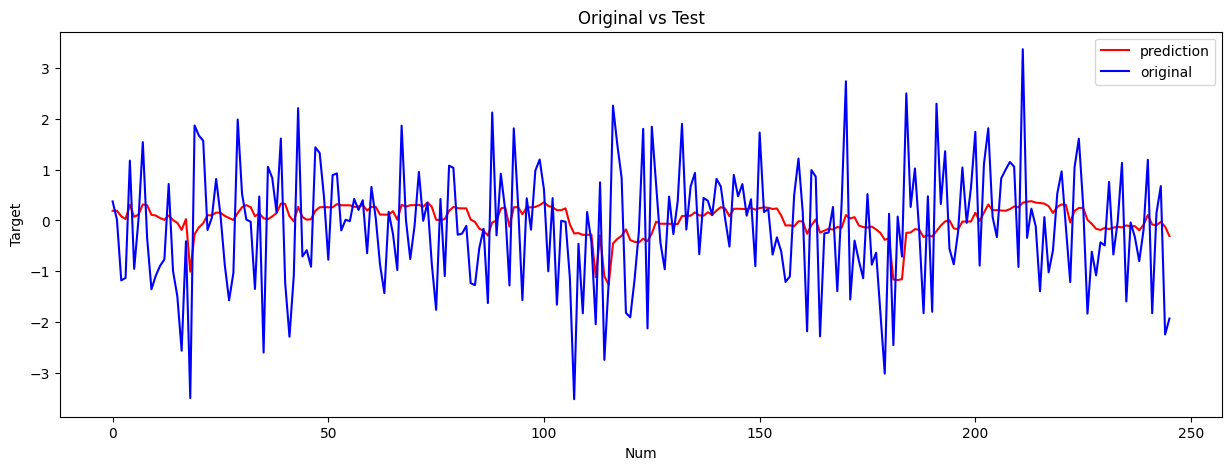

In [ ]:
plt.plot(preds,'r', label='prediction')
plt.plot(y_test.values,'b', label='original')
plt.xlabel('Num')
plt.ylabel('Target')
plt.legend()
plt.title('Original vs Test')
plt.show()

#facebook's prophet

In [ ]:
# cross validation_2
params = {"objective":"reg:linear",'n_estimators': 500, 'colsample_bytree': 0.3,'learning_rate': 0.01,'max_depth': 5, 'alpha': 10, 'min_child_weight':3}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params,
                    nfold=5,num_boost_round=10,early_stopping_rounds=50,
                    metrics="rmse", as_pandas=True, seed=123)
print((cv_results["test-rmse-mean"]).tail(1))
# 1.19683
# 1.15654
# 1.277872 -  'learning_rate': 0.001
# 1.266751
# 1.256809 -  'learning_rate': 0.01

[10:24:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[10:24:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[10:24:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[10:24:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:26] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[10:24:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:26] WARNING: ../src/learner.cc:767: 
P

In [ ]:
cv_results.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
45         1.278892        0.060608        1.265595       0.218657
46         1.278598        0.060619        1.265413       0.218640
47         1.278277        0.060642        1.265194       0.218607
48         1.277931        0.060665        1.264926       0.218583
49         1.277581        0.060680        1.264673       0.218562

[03:33:53] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


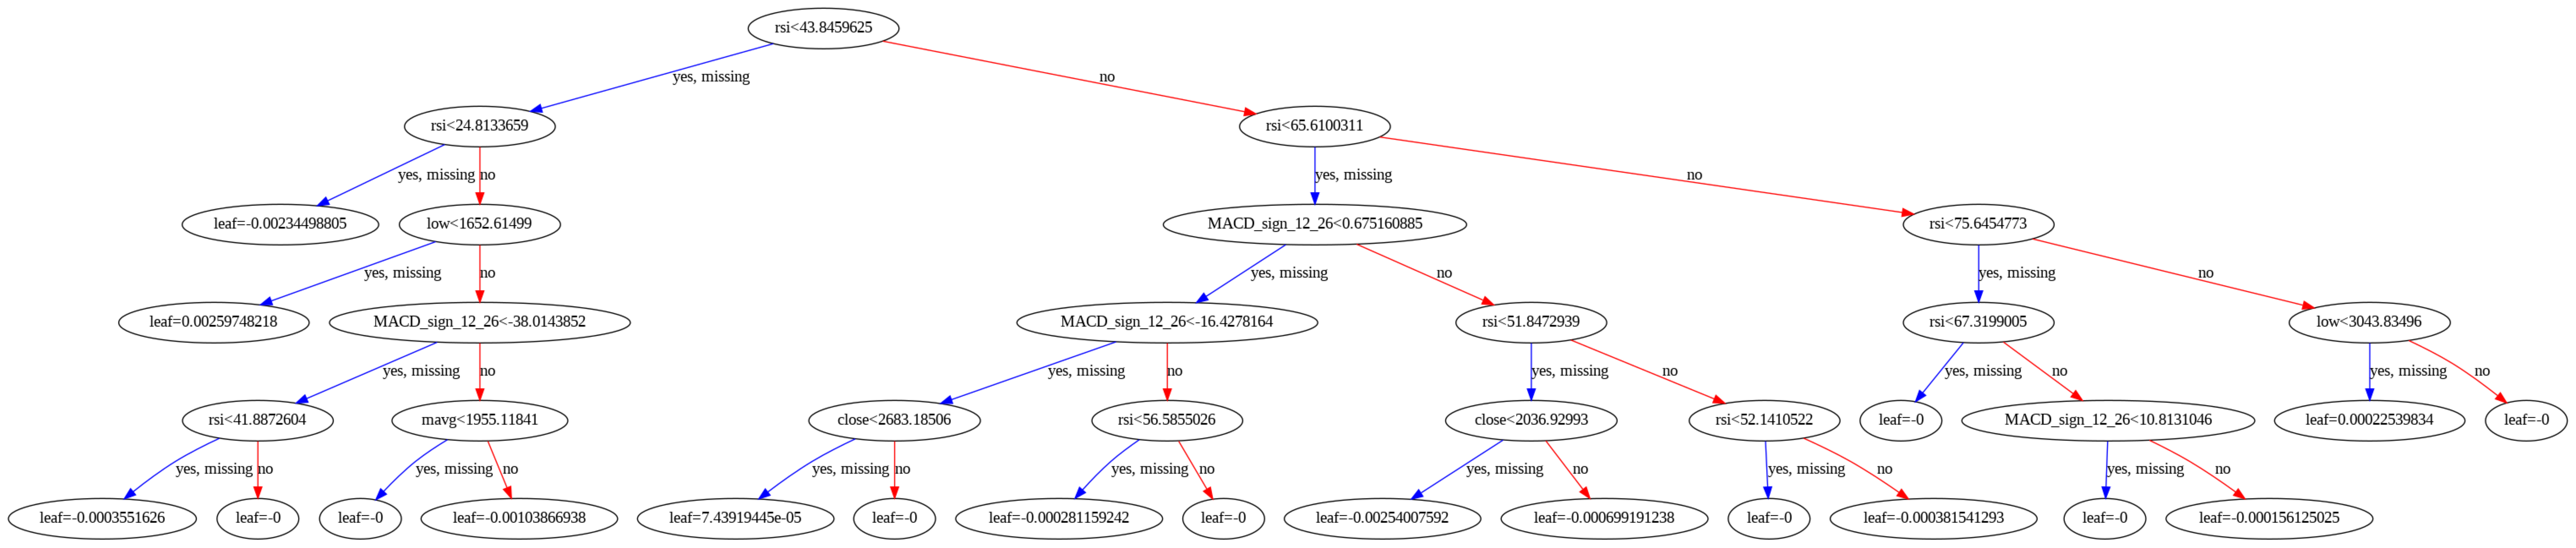

In [ ]:
import matplotlib.pyplot as plt
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=50)
xgb.plot_tree(xg_reg,num_trees=9)
plt.rcParams['figure.figsize'] = [80, 50]
plt.show()

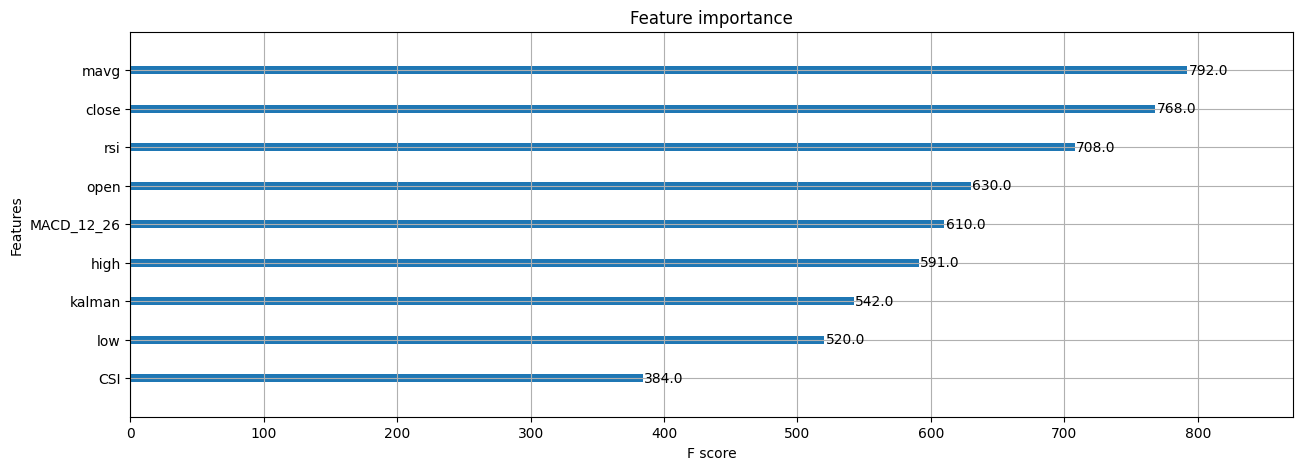

In [ ]:
xgb.plot_importance(xg_reg)
plt.show()

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 객체 생성, 일단은 트리 100개만 만듦
xgb_model = XGBRegressor(n_estimators=500) # 500으로 교체

# 후보 파라미터 선정
params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75], 'learning_rate':[0.001,0.05]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(xgb_model, param_grid=params, cv=5)

# 파라미터 튜닝 시작
gridcv.fit(X_train, y_train, early_stopping_rounds=50, eval_metric='rmse', eval_set=[(X_test, y_test), (X_val, y_val)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)
# {'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_weight': 3}
# {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 1}
# {'colsample_bytree': 0.5, 'max_depth': 7, 'min_child_weight': 3} - scale
# {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 1}
# 와 러닝레이트추가했더니 10분 걸림 {'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1}

In [ ]:
# 1차적으로 튜닝된 파라미터를 가지고 객체 생성

#learning rate= 0.02 -> 0.001으로 시도 -> 0.01-> 0.05
xgb_model = XGBRegressor(n_estimators=100,learning_rate=0.05, max_depth=7, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)
# 학습
rg = xgb_model.fit(X_train, y_train, early_stopping_rounds=50, eval_metric='rmse', eval_set= [(X_train, y_train), (X_val, y_val)]) #early_stopping_rounds=100 => 50
preds = rg.predict(X_test)


from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
# RMSE: 1.083631
# RMSE: 1.178757
# RMSE: 1.198415 - scale
# RMSE: 1.194934
# RMSE: 1.185155 -> 0.01
# RMSE: 1.200928 -> early stopping 100
# RMSE: 1.185155
# RMSE: 1.160466
# RMSE: 1.012431 -> shuffle false
# RMSE: 1.012431

In [ ]:
rg.history['loss']

AttributeError: ignored

range(0, 100)


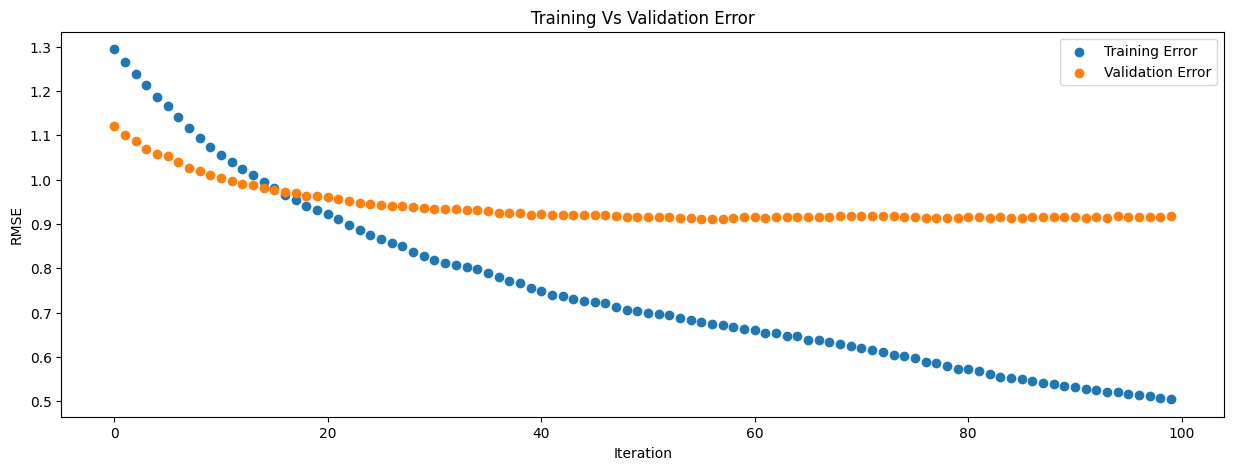

In [ ]:
import matplotlib.pyplot as plt

eval_result = rg.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))
print(training_rounds)

plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
# plt.scatter(x=training_rounds,y=rmse,label='Validation Error')

plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.rcParams['figure.figsize'] = [15, 5]
plt.legend()

#과적합 그래프
#테스트 데이터로 그래프 확인 - 3개 값이 비슷한(일반화) -> validation
#error -> 해결

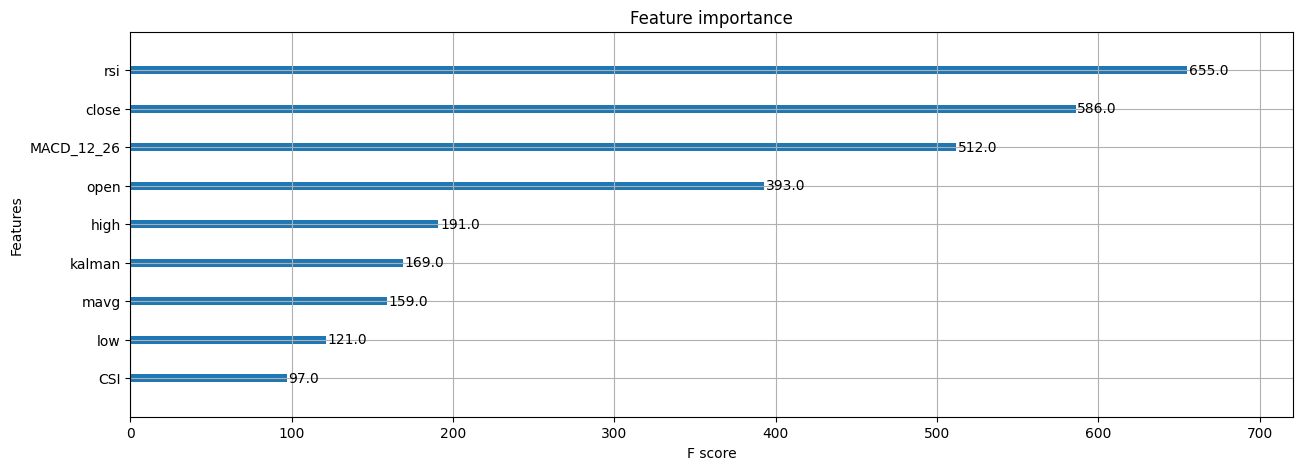

In [ ]:
xgb.plot_importance(rg)
plt.show()

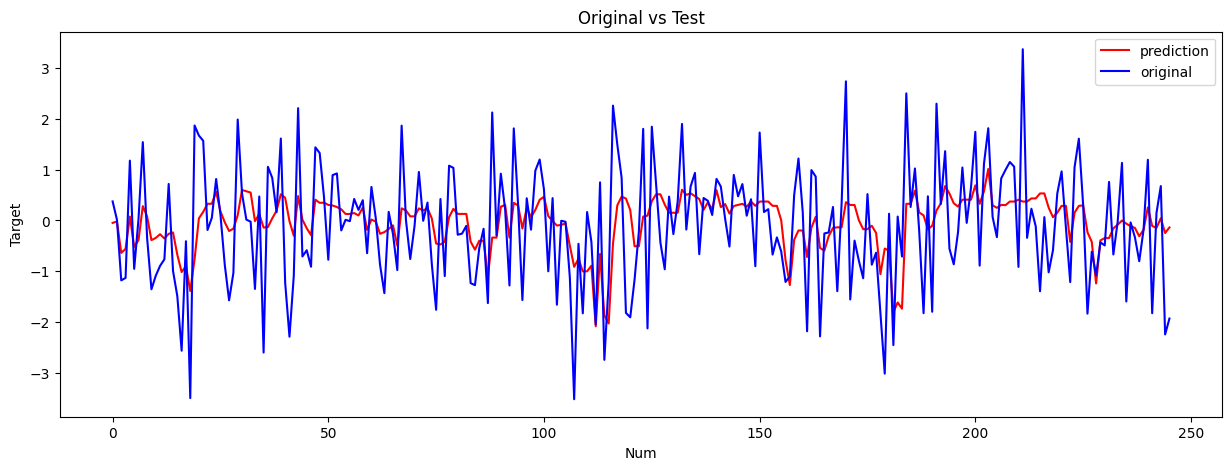

In [ ]:
plt.plot(preds,'r', label='prediction')
plt.plot(y_test.values,'b', label='original')
plt.xlabel('Num')
plt.ylabel('Target')
plt.legend()
plt.title('Original vs Test')
plt.show()

# 이상치
# 후보정 - 신뢰구간, iqr값(box plot)
# 종속변수 몇개 빼보기 (상관관계가 높은, 유사값 중 하나)
# 날짜 - 신문 검색 - 외부영향

In [ ]:
preds.min()

-4.4648867

In [ ]:
y_test1 = y_test.to_frame()

In [ ]:
y_tes1t = pd.to_dataFrame(y_test)

date
2021-08-03    0.437475
2017-02-23    0.048419
2022-12-12   -0.670562
2017-08-07    0.137761
2022-06-29   -1.820742
                ...   
2021-03-05   -0.566126
2019-01-08   -0.580728
2019-07-29   -1.780028
2018-04-16    0.098572
2017-05-11    1.156327
Name: target, Length: 246, dtype: float64

In [ ]:
a = y_test1.max().values[0]
y_test1[y_test1['target']==a]
# 에??? 22년 test 데이터에 20년???

target
date                
2020-03-20  7.444225

In [ ]:
import joblib
# 파일명
filename = 'ks_xgb_4.model'

# 모델 저장
joblib.dump(xgb_model, open(filename, 'wb'))


# LSTM
https://pasus.tistory.com/266
https://6mini.github.io/deep%20learning/2021/10/21/NNHyperparameter/


In [ ]:
raw_train.columns

Index(['date', 'close', 'open', 'high', 'low', 'rsi', 'MACD_12_26', 'mavg',
       'CSI', 'kalman', 'target'],
      dtype='object')

In [ ]:
# save original 'returns' prices for later
original_returns = raw_train['target'].values

# separate dates for future plotting
dates = pd.to_datetime(raw_train['date'])

In [ ]:
# variables for training
cols = list(raw_train)[0:13]

# new dataframe with only training data
stock_data = raw_train[cols].astype(float)

In [ ]:
stock_data

close     open     high      low        rsi  MACD_12_26  \
date                                                                    
2017-01-02  2026.16  2022.23  2031.79  2015.68  51.846817    1.534583   
2017-01-03  2043.97  2034.31  2044.07  2028.47  51.846817    1.534583   
2017-01-04  2045.64  2046.29  2046.29  2040.61  51.846817    1.534583   
2017-01-05  2041.95  2045.52  2046.50  2039.49  51.846817    1.534583   
2017-01-06  2049.12  2048.11  2051.84  2045.66  51.846817    1.534583   
...             ...      ...      ...      ...        ...         ...   
2022-12-23  2313.69  2325.86  2333.08  2311.90  38.363622  -15.931807   
2022-12-26  2317.14  2312.54  2321.92  2304.20  39.169097  -18.026966   
2022-12-27  2332.79  2327.52  2335.99  2321.48  42.819515  -18.214604   
2022-12-28  2280.45  2296.45  2296.45  2276.90  35.209547  -22.329310   
2022-12-29  2236.40  2265.73  2272.67  2236.38  30.324860  -28.812578   

            MACD_sign_12_26        hband         mavg        lband   CSI  \
date                                                                       
2017-01-02         1.568948  2520.977931  2436.844485  2352.711040  93.3   
2017-01-03         1.568948  2520.977931  2436.844485  2352.711040  93.3   
2017-01-04         1.568948  2520.977931  2436.844485  2352.711040  93.3   
2017-01-05         1.568948  2520.977931  2436.844485  2352.711040  93.3   
2017-01-06         1.568948  2520.977931  2436.844485  2352.711040  93.3   
...                     ...          ...          ...          ...   ...   
2022-12-23        -5.996773  2473.727635  2386.713000  2299.698365  90.2   
2022-12-26        -8.402811  2473.609437  2382.156500  2290.703563  90.2   
2022-12-27       -10.365170  2467.817580  2377.126500  2286.435420  90.2   
2022-12-28       -12.757998  2456.431601  2367.522500  2278.613399  90.2   
2022-12-29       -15.968914  2446.057588  2355.350500  2264.643412  90.2   

               target  
date                   
2017-01-02 -16.745712  
2017-01-03   0.879003  
2017-01-04   0.081704  
2017-01-05  -0.180384  
2017-01-06   0.351135  
...               ...  
2022-12-23  -1.826259  
2022-12-26   0.149112  
2022-12-27   0.675402  
2022-12-28  -2.243665  
2022-12-29  -1.931636  

[1475 rows x 12 columns]

In [ ]:
# normalize the dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler = scaler.fit(stock_data)
stock_data_scaled = scaler.transform(stock_data)

In [ ]:
https://shyu0522.tistory.com/14

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=246, random_state=123)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=248, random_state=123)

In [ ]:
# split to train data and test data
n_train = 981
train_data_scaled = stock_data_scaled[0: n_train]
train_dates = dates[0: n_train]

n_validation = n_train + 248
val_data_scaled = stock_data_scaled[n_train: n_validation]
val_dates = dates[n_train: n_validation]

n_test = n_validation

test_data_scaled = stock_data_scaled[n_test:]
test_dates = dates[n_test:]

In [ ]:
len(val_data_scaled)

248

In [ ]:
len(test_data_scaled)

246

In [ ]:
import numpy as np
# data reformatting for LSTM
pred_days = 1  # prediction period - 3months
seq_len = 10   # sequence length = past days for future prediction.
input_dim = 12  # input_dimension = ['close', 'open', 'high', 'low', 'rsi', 'MACD_12_26', 'MACD_sign_12_26', 'hband', 'mavg', 'lband', 'CSI', 'target']

trainX = []
trainY = []
valX = []
valY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(val_data_scaled)-pred_days +1):
    valX.append(val_data_scaled[i - seq_len:i, 0:val_data_scaled.shape[1]])
    valY.append(val_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
valX, valY = np.array(valX), np.array(valY)
testX, testY = np.array(testX), np.array(testY)

In [ ]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)
print(valX.shape, valY.shape)

(971, 10, 12) (971, 1)
(236, 10, 12) (236, 1)
(238, 10, 12) (238, 1)


In [ ]:
!pip install keras

In [ ]:
# LSTM model
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]),
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

In [ ]:
# specify your learning rate
learning_rate = 0.001
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
validation_data = (valX,valY)

Epoch 1/30
243/243 [==============================] - 15s 19ms/step - loss: 0.0203 - val_loss: 0.7044
Epoch 2/30
243/243 [==============================] - 4s 15ms/step - loss: 0.0065 - val_loss: 0.5441
Epoch 3/30
243/243 [==============================] - 3s 12ms/step - loss: 0.0065 - val_loss: 0.5732
Epoch 4/30
243/243 [==============================] - 3s 12ms/step - loss: 0.0063 - val_loss: 0.5928
Epoch 5/30
243/243 [==============================] - 3s 14ms/step - loss: 0.0056 - val_loss: 0.6275
Epoch 6/30
243/243 [==============================] - 5s 19ms/step - loss: 0.0049 - val_loss: 0.5933
Epoch 7/30
243/243 [==============================] - 4s 17ms/step - loss: 0.0049 - val_loss: 0.4413
Epoch 8/30
243/243 [==============================] - 3s 12ms/step - loss: 0.0055 - val_loss: 0.3124
Epoch 9/30
243/243 [==============================] - 3s 14ms/step - loss: 0.0048 - val_loss: 0.3478
Epoch 10/30
243/243 [==============================] - 4s 17ms/step - loss: 0.0044 - val_l

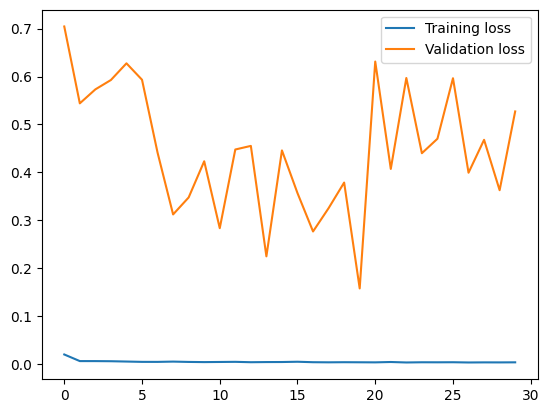

In [ ]:
# import matplotlib.pyplot as plt
# try:
#     model.load_weights('./lstm_weights_2.h5')
#     print("Loaded model weights from disk")
# except:
    # Fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=4, validation_data=validation_data,
                  verbose=1) #validation - 과적합 방지 & loss 가 작을수록 좋은 모델이니 그것을 선택함
# Save model weights after training
model.save_weights('./lstm_weights_6.h5')

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
try:
    model.load_weights('./lstm_weights_3.h5')
    print("Loaded model weights from disk")
except:
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                     verbose=1) #validation_data
    # Save model weights after training
    model.save_weights('./lstm_weights_3.h5')

plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [ ]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

8/8 [==============================] - 1s 5ms/step
(236, 1) (236, 1)


In [ ]:
# generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# substitute predictions into the last column
mean_values_pred[:, -1] = np.squeeze(prediction)

# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,-1]
print(y_pred.shape)


(236,)


In [ ]:
# generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# substitute testY into the last column
mean_values_testY[:, -1] = np.squeeze(testY)
# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,-1]
print(testY_original.shape)

(236,)


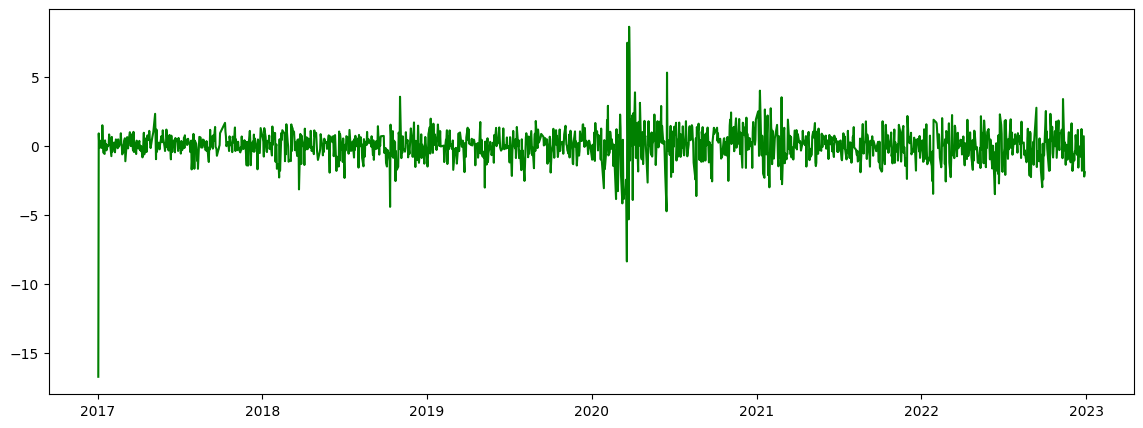

In [ ]:
# plotting
plt.figure(figsize=(14, 5))

# plot original 'returns' prices
plt.plot(dates, original_returns, color='green', label='Original Returns')

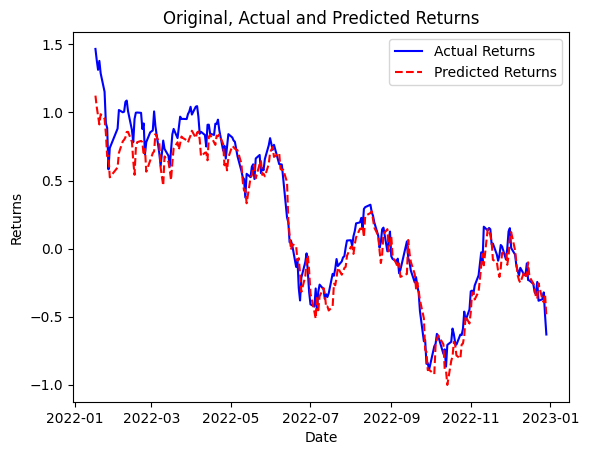

In [ ]:
# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Returns')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Original, Actual and Predicted Returns')
plt.legend()
plt.show()

In [ ]:
len(y_pred)

236

In [ ]:
adjusted_start

NameError: ignored

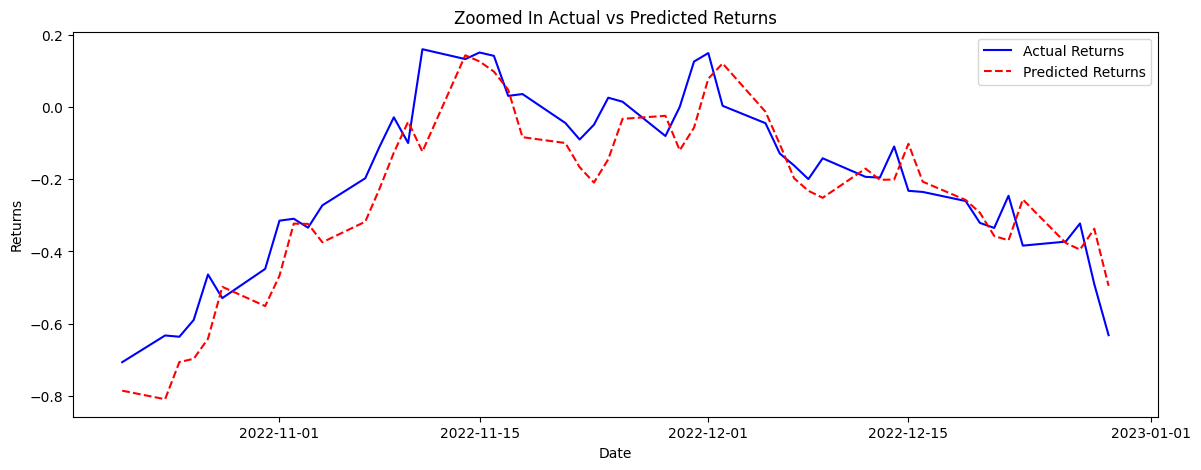

In [ ]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Returns')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Returns')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Zoomed In Actual vs Predicted Returns')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print("RMSE: %f" % (rmse))
# RMSE: 0.160966 ..?gg
# RMSE: 0.139228 옹예

RMSE: 0.139228


In [ ]:
model.save('ks_lstm.h5')

#추가적으로 할일 (0822)
- 상관관계가 높은 변수 제외  
다중공선성 문제를 방지 -> 유사도 높은 것들은 하나의 값만 넣기
- 종속변수 정규화(xgboost) -> 파라미터/ standard는 오히려 성능 x
- 앙상블 (참고: https://knowallworld.tistory.com/399)
  - ligthgbm이랑 해보자


In [ ]:
# 모델 불러오기
xgb_model = joblib.load(open(filename, 'rb'))

In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('ks_lstm.h5')

In [ ]:
raw_train.corr()

close      open      high       low       rsi  MACD_12_26  \
close            1.000000  0.998375  0.999124  0.999388  0.093970    0.207617   
open             0.998375  1.000000  0.999412  0.999109  0.077492    0.202925   
high             0.999124  0.999412  1.000000  0.998981  0.079538    0.202265   
low              0.999388  0.999109  0.998981  1.000000  0.091370    0.208615   
rsi              0.093970  0.077492  0.079538  0.091370  1.000000    0.792040   
MACD_12_26       0.207617  0.202925  0.202265  0.208615  0.792040    1.000000   
MACD_sign_12_26  0.222400  0.220860  0.220553  0.223218  0.654775    0.957104   
hband            0.961964  0.964015  0.965907  0.960180 -0.083501    0.038903   
mavg             0.976027  0.977958  0.978073  0.976111 -0.066910    0.069170   
lband            0.969215  0.970984  0.969325  0.971162 -0.048918    0.097907   
CSI              0.421084  0.422053  0.414838  0.429298  0.004418    0.008078   
target           0.034906 -0.006074  0.008983  0.017759  0.319375    0.072864   

                 MACD_sign_12_26     hband      mavg     lband       CSI  \
close                   0.222400  0.961964  0.976027  0.969215  0.421084   
open                    0.220860  0.964015  0.977958  0.970984  0.422053   
high                    0.220553  0.965907  0.978073  0.969325  0.414838   
low                     0.223218  0.960180  0.976111  0.971162  0.429298   
rsi                     0.654775 -0.083501 -0.066910 -0.048918  0.004418   
MACD_12_26              0.957104  0.038903  0.069170  0.097907  0.008078   
MACD_sign_12_26         1.000000  0.093409  0.123129  0.150169  0.038487   
hband                   0.093409  1.000000  0.989291  0.957467  0.361197   
mavg                    0.123129  0.989291  1.000000  0.989328  0.427363   
lband                   0.150169  0.957467  0.989328  1.000000  0.484285   
CSI                     0.038487  0.361197  0.427363  0.484285  1.000000   
target                  0.015550 -0.039216 -0.041348 -0.042593 -0.025145   

                   target  
close            0.034906  
open            -0.006074  
high             0.008983  
low              0.017759  
rsi              0.319375  
MACD_12_26       0.072864  
MACD_sign_12_26  0.015550  
hband           -0.039216  
mavg            -0.041348  
lband           -0.042593  
CSI             -0.025145  
target           1.000000

In [ ]:
raw_train.drop('hband', axis=1, inplace=True)
raw_train.drop('lband', axis=1, inplace=True)
raw_train.drop('MACD_sign_12_26', axis=1, inplace=True)

In [ ]:
raw_train

close     open     high      low        rsi  MACD_12_26  \
date                                                                    
2017-01-02  2026.16  2022.23  2031.79  2015.68  51.846817    1.534583   
2017-01-03  2043.97  2034.31  2044.07  2028.47  51.846817    1.534583   
2017-01-04  2045.64  2046.29  2046.29  2040.61  51.846817    1.534583   
2017-01-05  2041.95  2045.52  2046.50  2039.49  51.846817    1.534583   
2017-01-06  2049.12  2048.11  2051.84  2045.66  51.846817    1.534583   
...             ...      ...      ...      ...        ...         ...   
2022-12-23  2313.69  2325.86  2333.08  2311.90  38.363622  -15.931807   
2022-12-26  2317.14  2312.54  2321.92  2304.20  39.169097  -18.026966   
2022-12-27  2332.79  2327.52  2335.99  2321.48  42.819515  -18.214604   
2022-12-28  2280.45  2296.45  2296.45  2276.90  35.209547  -22.329310   
2022-12-29  2236.40  2265.73  2272.67  2236.38  30.324860  -28.812578   

                   mavg   CSI     target  
date                                      
2017-01-02  2436.844485  93.3 -16.745712  
2017-01-03  2436.844485  93.3   0.879003  
2017-01-04  2436.844485  93.3   0.081704  
2017-01-05  2436.844485  93.3  -0.180384  
2017-01-06  2436.844485  93.3   0.351135  
...                 ...   ...        ...  
2022-12-23  2386.713000  90.2  -1.826259  
2022-12-26  2382.156500  90.2   0.149112  
2022-12-27  2377.126500  90.2   0.675402  
2022-12-28  2367.522500  90.2  -2.243665  
2022-12-29  2355.350500  90.2  -1.931636  

[1475 rows x 9 columns]

In [ ]:
df = raw_train.loc[:,'close']

In [ ]:
!pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48444 sha256=0fa935b243dad240fdd7513861c6bcf0ca497e25777363ed6c053710950554f4
  Stored in directory: /root/.cache/pip/wheels/76/33/ef/5f332226e13a5089c6dd4b01cc2bcb59491d18f955fa2d3807
Successfully built pykalman


In [ ]:
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

In [ ]:
state_means, _ = kf.filter(df)

In [ ]:
df_smoothed = df.to_frame('close')
df_smoothed['Kalman Filter'] = state_means

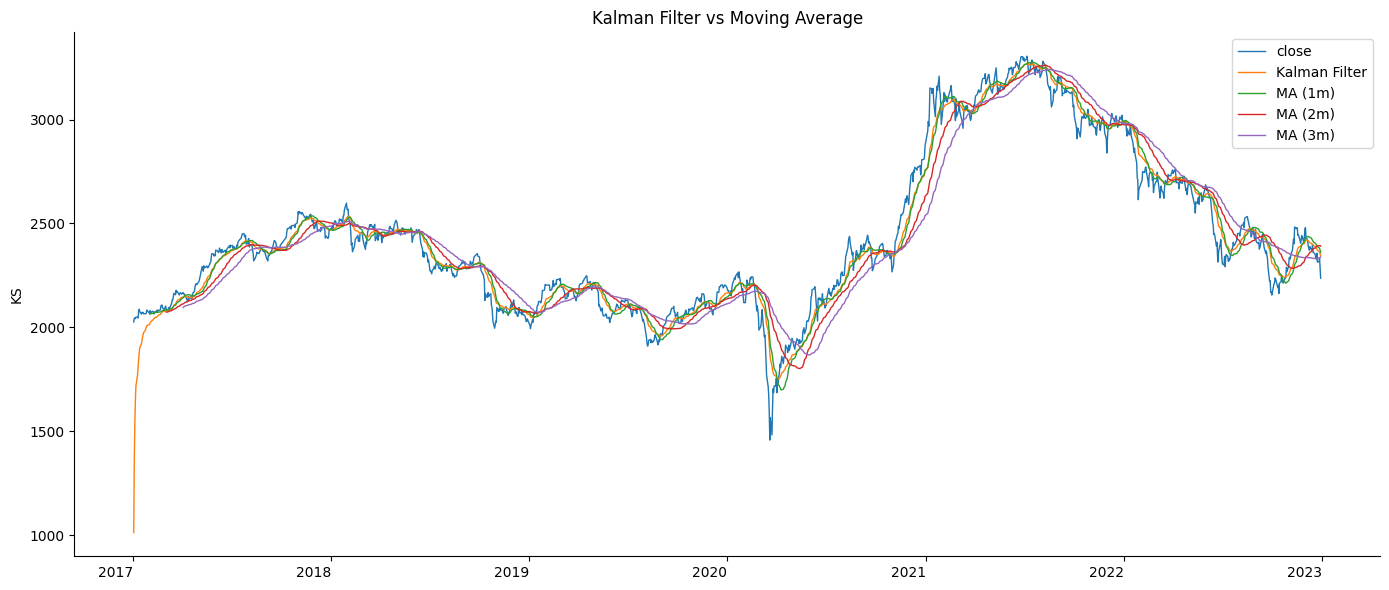

In [ ]:
for months in [1,2,3]:
    df_smoothed[f'MA ({months}m)'] = df.rolling(window=months*21).mean()

ax = df_smoothed.plot(title='Kalman Filter vs Moving Average', figsize=(14,6), lw=1, rot=0)
ax.set_xlabel('')
ax.set_ylabel('KS')
plt.tight_layout()
import seaborn as sns
sns.despine();

In [ ]:
raw_train['kalman'] = df_smoothed['Kalman Filter']

In [ ]:
raw_train.corr()

close      open      high       low       rsi  MACD_12_26  \
close       1.000000  0.998375  0.999124  0.999388  0.093970    0.207617   
open        0.998375  1.000000  0.999412  0.999109  0.077492    0.202925   
high        0.999124  0.999412  1.000000  0.998981  0.079538    0.202265   
low         0.999388  0.999109  0.998981  1.000000  0.091370    0.208615   
rsi         0.093970  0.077492  0.079538  0.091370  1.000000    0.792040   
MACD_12_26  0.207617  0.202925  0.202265  0.208615  0.792040    1.000000   
mavg        0.976027  0.977958  0.978073  0.976111 -0.066910    0.069170   
CSI         0.421084  0.422053  0.414838  0.429298  0.004418    0.008078   
target      0.034906 -0.006074  0.008983  0.017759  0.319375    0.072864   
kalman      0.981646  0.983418  0.983729  0.981539 -0.051846    0.079665   

                mavg       CSI    target    kalman  
close       0.976027  0.421084  0.034906  0.981646  
open        0.977958  0.422053 -0.006074  0.983418  
high        0.978073  0.414838  0.008983  0.983729  
low         0.976111  0.429298  0.017759  0.981539  
rsi        -0.066910  0.004418  0.319375 -0.051846  
MACD_12_26  0.069170  0.008078  0.072864  0.079665  
mavg        1.000000  0.427363 -0.041348  0.977631  
CSI         0.427363  1.000000 -0.025145  0.432337  
target     -0.041348 -0.025145  1.000000 -0.002980  
kalman      0.977631  0.432337 -0.002980  1.000000

In [ ]:
raw_train.columns

Index(['date', 'close', 'open', 'high', 'low', 'rsi', 'MACD_12_26', 'mavg',
       'CSI', 'kalman', 'target'],
      dtype='object')

In [ ]:
raw_train = raw_train[['close', 'open', 'high', 'low', 'rsi', 'MACD_12_26', 'mavg', 'CSI', 'kalman',
       'target']]

In [ ]:
raw_train = raw_train.astype('float')

In [ ]:
raw_train.to_csv("adj_raw_train.csv")

In [ ]:
raw_train = raw_train.reset_index()

##  Prophet
- https://facebook.github.io/prophet/docs/quick_start.html

In [4]:
import pandas as pd
raw_train = pd.read_csv("/content/drive/MyDrive/adj_raw_train.csv")

In [5]:
df = pd.DataFrame()

In [9]:
df

ds          y
0     2017-01-02 -16.745712
1     2017-01-03   0.879003
2     2017-01-04   0.081704
3     2017-01-05  -0.180384
4     2017-01-06   0.351135
...          ...        ...
1470  2022-12-23  -1.826259
1471  2022-12-26   0.149112
1472  2022-12-27   0.675402
1473  2022-12-28  -2.243665
1474  2022-12-29  -1.931636

[1475 rows x 2 columns]

In [6]:
df['DS'] = raw_train['date']

In [7]:
df['Y'] = raw_train['target']

In [8]:
df.columns = ['ds','y']

In [21]:
from prophet import Prophet
m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vz90ckv/_sv98un4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vz90ckv/52rn6ss8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16432', 'data', 'file=/tmp/tmp3vz90ckv/_sv98un4.json', 'init=/tmp/tmp3vz90ckv/52rn6ss8.json', 'output', 'file=/tmp/tmp3vz90ckv/prophet_modeljtrz23tp/prophet_model-20230823005411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:54:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:54:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [22]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
1835 2023-12-25
1836 2023-12-26
1837 2023-12-27
1838 2023-12-28
1839 2023-12-29

In [23]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
1835 2023-12-25 -0.489701   -1.994737    0.983366
1836 2023-12-26 -0.191899   -1.635290    1.272980
1837 2023-12-27 -0.386970   -1.988977    1.089107
1838 2023-12-28 -0.434483   -1.965281    1.063594
1839 2023-12-29 -0.315242   -1.734297    1.215756

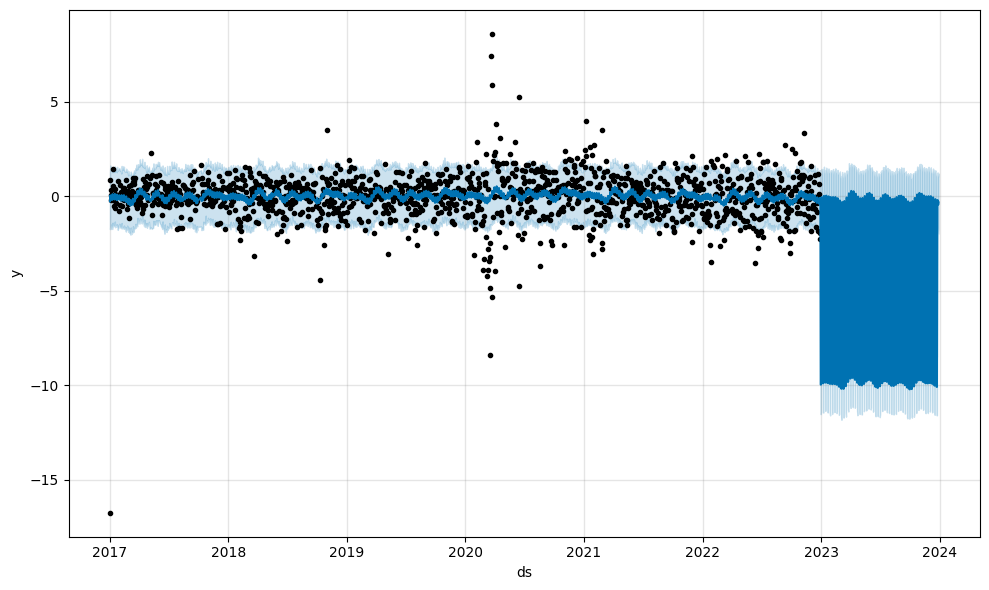

In [24]:
fig1 = m.plot(forecast)

In [26]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

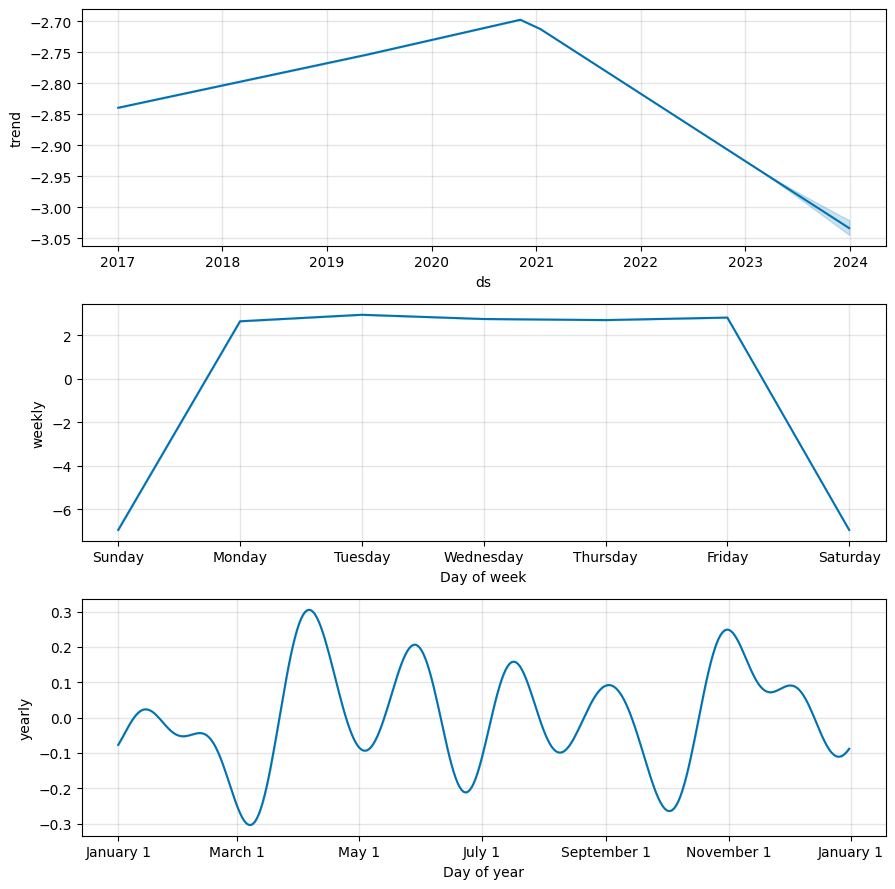

In [25]:
fig2 = m.plot_components(forecast)

In [28]:
# plot_components_plotly(m, forecast)

- 수익률로만 따지니까 이상하게 나와서 정규화 다시 해봄..

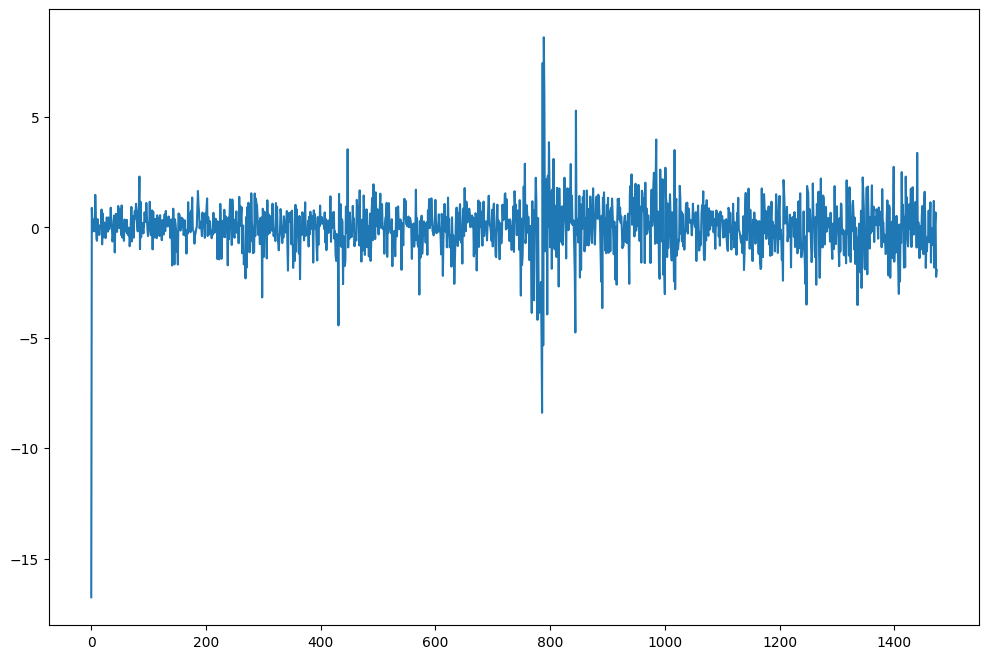

In [21]:
data = raw_train['target'].values
plt.figure(figsize=(12, 8))
plt.plot(data)
plt.show()

In [ ]:
# import plotly.graph_objects as go
# fig = go.Figure()
# fig.update_traces(x=data, selector=dict(type='ohlc'))
# fig.update_traces(value=data, selector=dict(type='indicator'))

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = np.array(data).reshape(-1,1)    # 표준화를 하기 위해 사이즈를 (-1,1)로 조정

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
scaled

array([[0.        ],
       [0.69533851],
       [0.6638831 ],
       ...,
       [0.68730594],
       [0.57214155],
       [0.58445186]])

In [25]:
df.drop('y', axis=1, inplace=True)

In [27]:
df['y'] = scaled

In [28]:
df

ds         y
0     2017-01-02  0.000000
1     2017-01-03  0.695339
2     2017-01-04  0.663883
3     2017-01-05  0.653543
4     2017-01-06  0.674513
...          ...       ...
1470  2022-12-23  0.588609
1471  2022-12-26  0.666543
1472  2022-12-27  0.687306
1473  2022-12-28  0.572142
1474  2022-12-29  0.584452

[1475 rows x 2 columns]

In [33]:
from prophet import Prophet

train_df = df.head(-246)

m = Prophet(seasonality_mode='additive')
m.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3_qo6h16/bfq6c04l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3_qo6h16/6p8d56f3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27601', 'data', 'file=/tmp/tmp3_qo6h16/bfq6c04l.json', 'init=/tmp/tmp3_qo6h16/6p8d56f3.json', 'output', 'file=/tmp/tmp3_qo6h16/prophet_models6ct3srx/prophet_model-20230823014953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


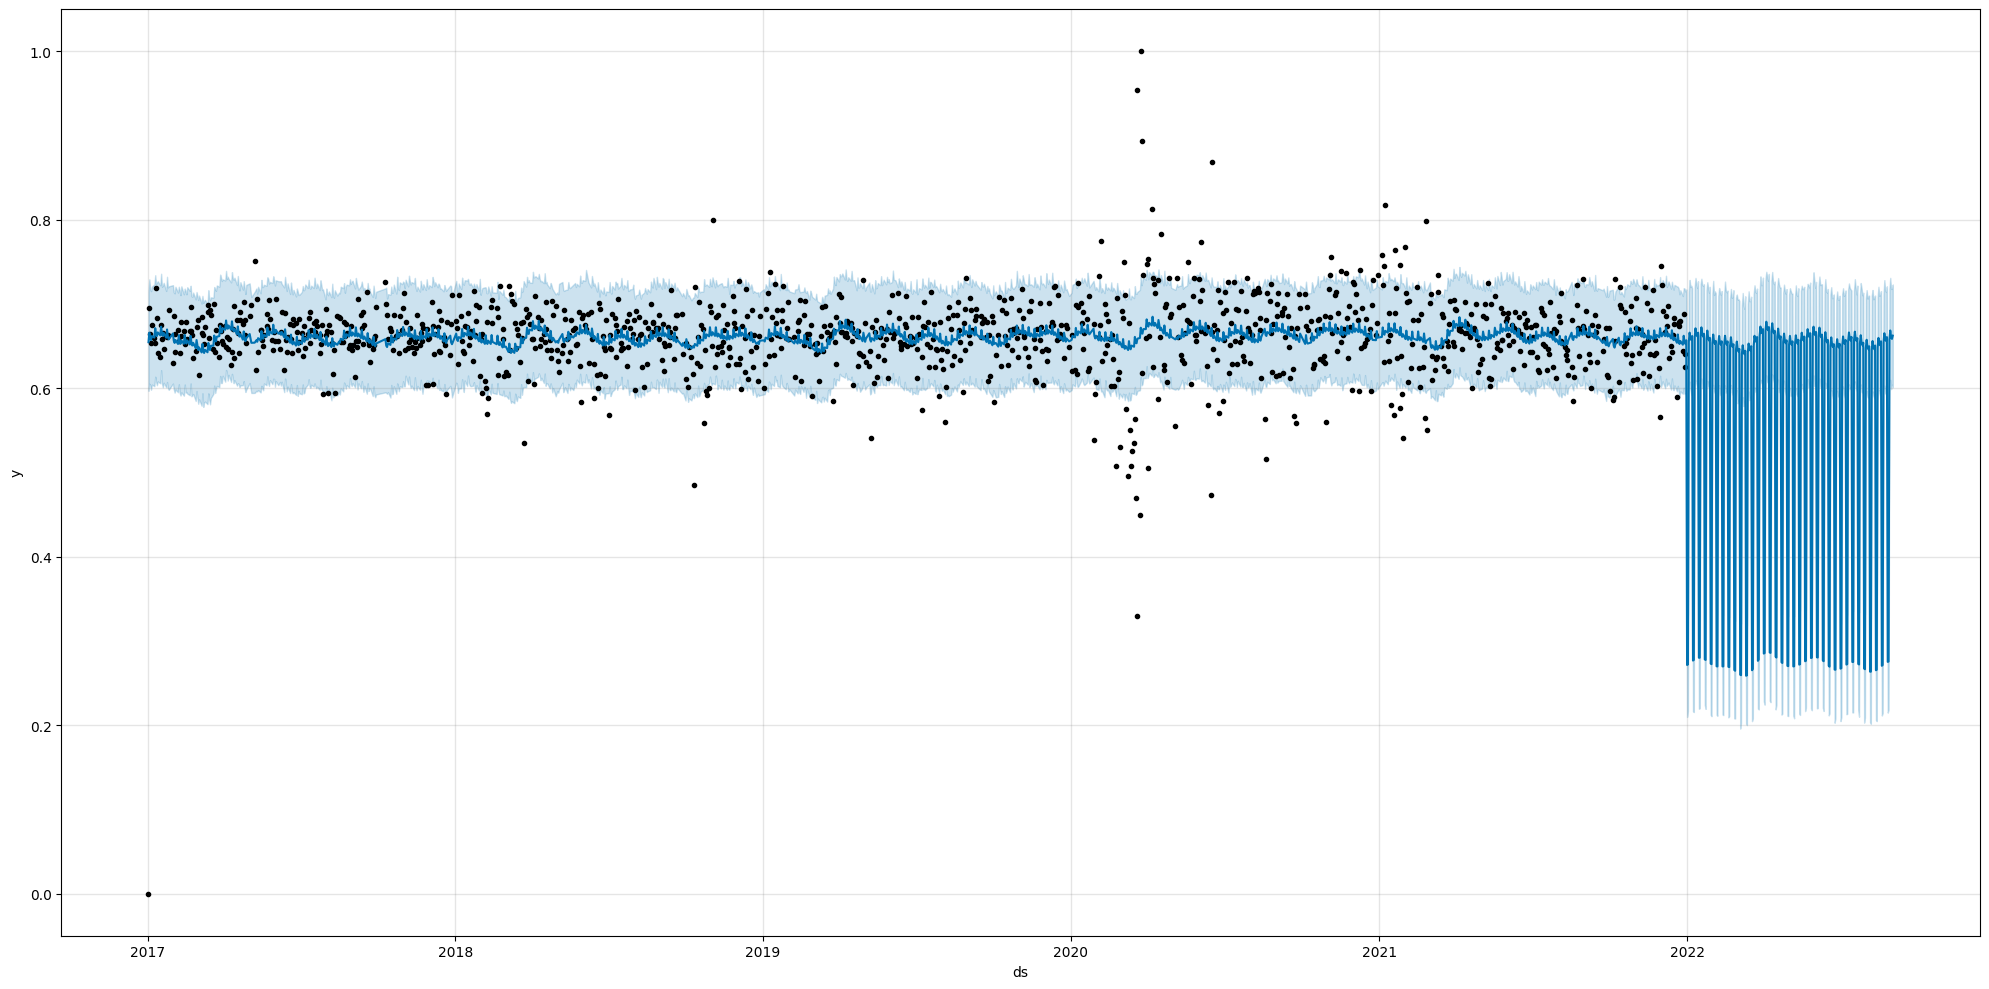

In [31]:
fig1 = m.plot(forecast, figsize=(20,10))

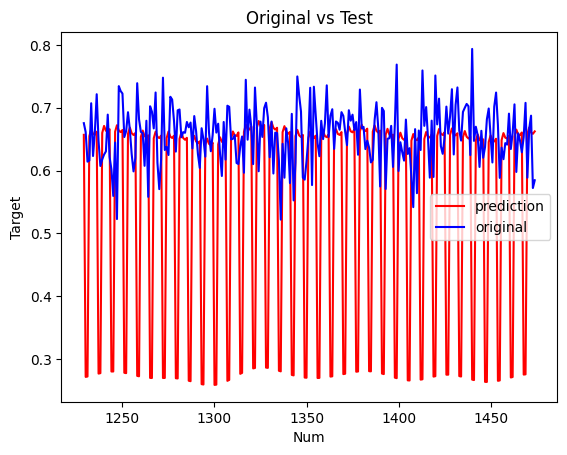

In [35]:
plt.plot(forecast.iloc[-246:,:].yhat,'r', label='prediction')
plt.plot(test_df.y,'b', label='original')
plt.xlabel('Num')
plt.ylabel('Target')
plt.legend()
plt.title('Original vs Test')
plt.show()

달라지는게 없었다...

In [30]:
future_df = df.copy()
future_df = m.make_future_dataframe(periods=246)
future_df.rename(columns={'date':'ds'},inplace=True)
forecast = m.predict(future_df)

In [51]:
from prophet import Prophet


train_df = df.head(-246)

m = Prophet(seasonality_mode='additive')
m.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vz90ckv/a7dpxfu_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vz90ckv/7m7lkpxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75232', 'data', 'file=/tmp/tmp3vz90ckv/a7dpxfu_.json', 'init=/tmp/tmp3vz90ckv/7m7lkpxp.json', 'output', 'file=/tmp/tmp3vz90ckv/prophet_modelc9fh9iev/prophet_model-20230823012323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [67]:
future_df = df.copy()
future_df = m.make_future_dataframe(periods=246)
future_df.rename(columns={'date':'ds'},inplace=True)
forecast = m.predict(future_df)

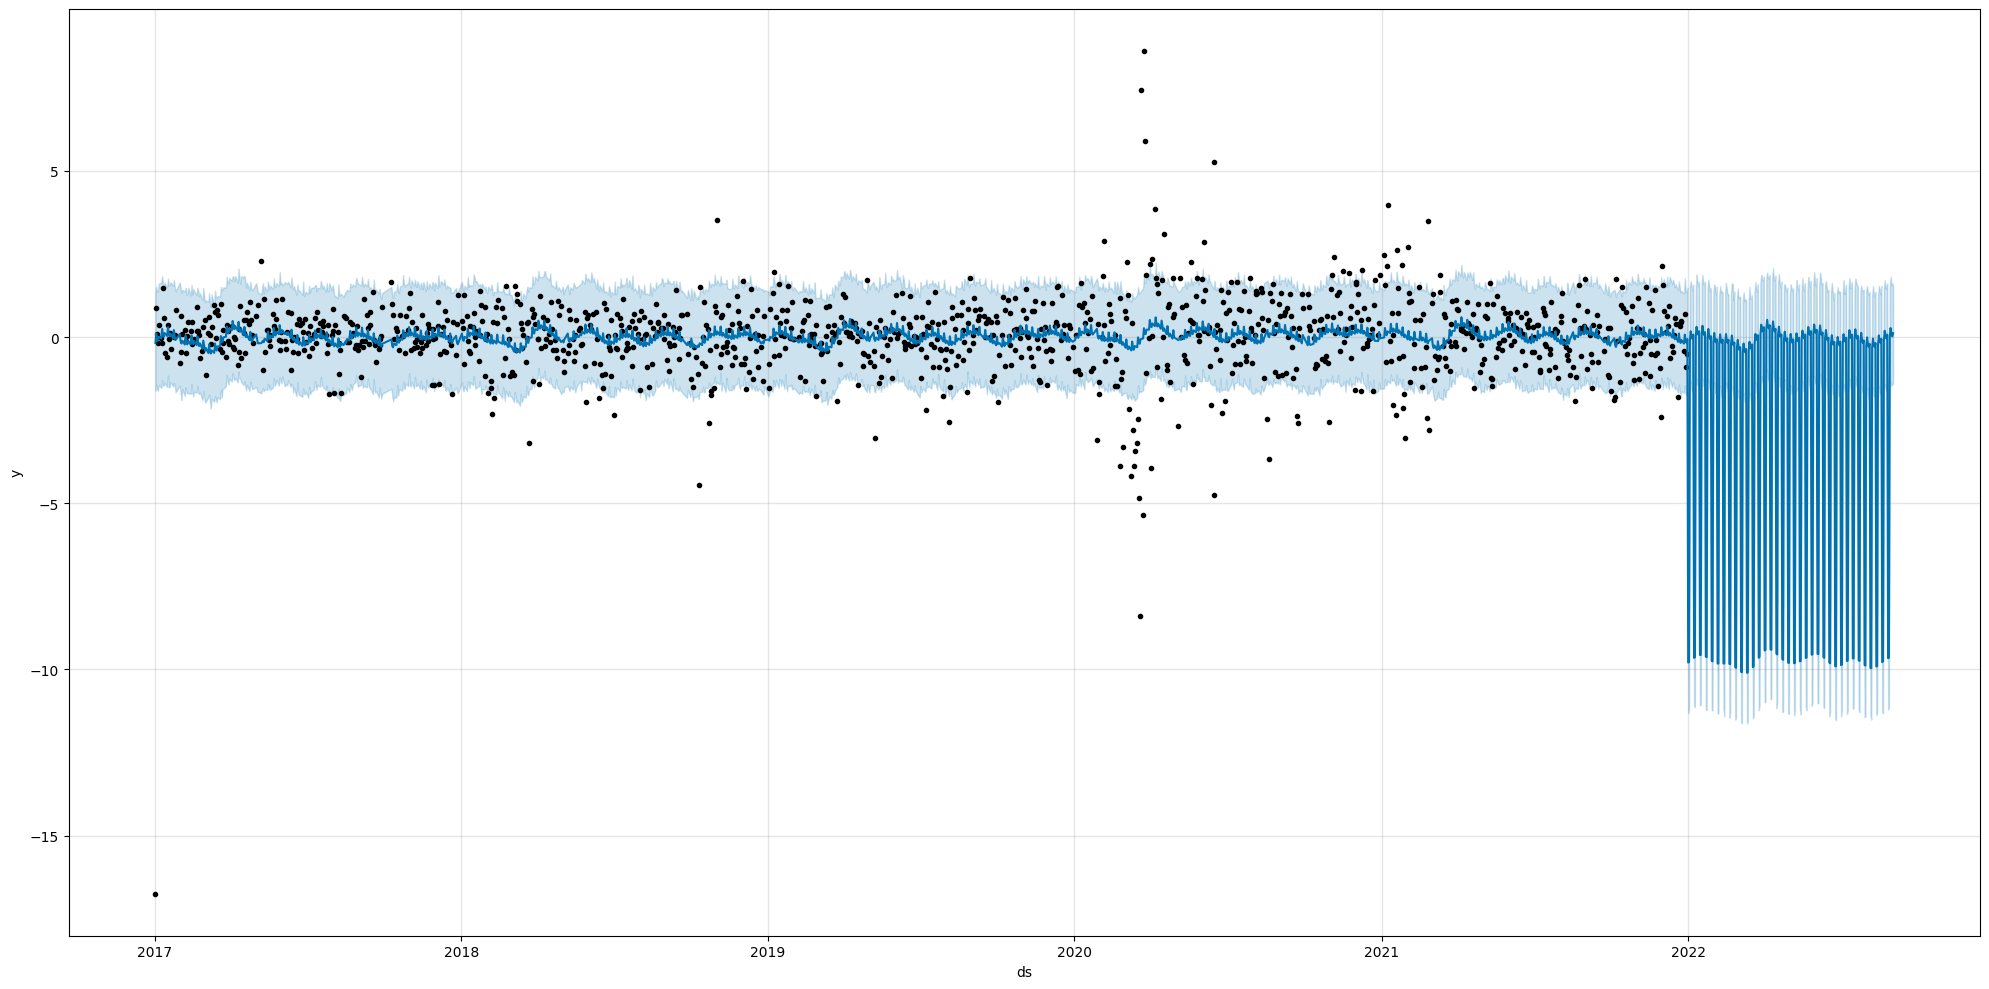

In [68]:
fig1 = m.plot(forecast, figsize=(20,10))

In [34]:
test_df = df.tail(246)

In [66]:
test_df.y

1229    0.373449
1230    0.015726
1231   -1.179899
1232   -1.132036
1233    1.176499
          ...   
1470   -1.826259
1471    0.149112
1472    0.675402
1473   -2.243665
1474   -1.931636
Name: y, Length: 246, dtype: float64

In [71]:
forecast.iloc[-246:,:].yhat

1229   -0.062641
1230   -9.793304
1231   -9.776141
1232   -0.114165
1233    0.171887
          ...   
1470   -0.000394
1471    0.271997
1472    0.070489
1473    0.018359
1474    0.115933
Name: yhat, Length: 246, dtype: float64

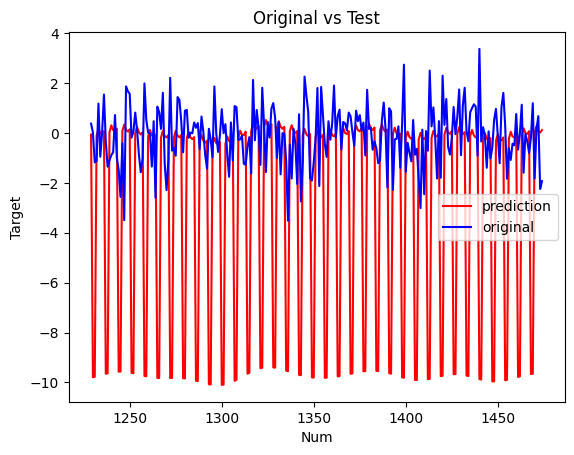

In [72]:
plt.plot(forecast.iloc[-246:,:].yhat,'r', label='prediction')
plt.plot(test_df.y,'b', label='original')
plt.xlabel('Num')
plt.ylabel('Target')
plt.legend()
plt.title('Original vs Test')
plt.show()


In [10]:
# prophet 모듈 세팅
from prophet import Prophet

# Day 단위로 데이터가 구성되어 있으므로, 일 단위 주기성 활성화
model = Prophet(daily_seasonality=True)

# 데이터 학습 시작 -> 기계학습
model.fit(df[['ds', 'y']].iloc[:-10])

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3_qo6h16/c6s789qo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3_qo6h16/qow_sqz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36170', 'data', 'file=/tmp/tmp3_qo6h16/c6s789qo.json', 'init=/tmp/tmp3_qo6h16/qow_sqz2.json', 'output', 'file=/tmp/tmp3_qo6h16/prophet_modelwfgdpt1z/prophet_model-20230823014014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
# 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 14일치 예측값
future = model.make_future_dataframe(periods=10)

# 주가 예측
forecast = model.predict(future)

In [12]:
# 필요한 컬럼만 보기
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11)

ds      yhat  yhat_lower  yhat_upper
1464 2022-12-15 -0.186974   -1.675542    1.417803
1465 2022-12-16 -0.075339   -1.423769    1.458976
1466 2022-12-17 -2.375232   -3.851345   -0.811536
1467 2022-12-18 -2.383938   -3.889134   -0.824188
1468 2022-12-19 -0.279084   -1.772650    1.327754
1469 2022-12-20  0.015028   -1.443925    1.490446
1470 2022-12-21 -0.179944   -1.691582    1.243374
1471 2022-12-22 -0.240671   -1.750239    1.243764
1472 2022-12-23 -0.123220   -1.735371    1.449186
1473 2022-12-24 -2.416334   -3.925292   -0.818932
1474 2022-12-25 -2.417465   -3.967492   -0.901257

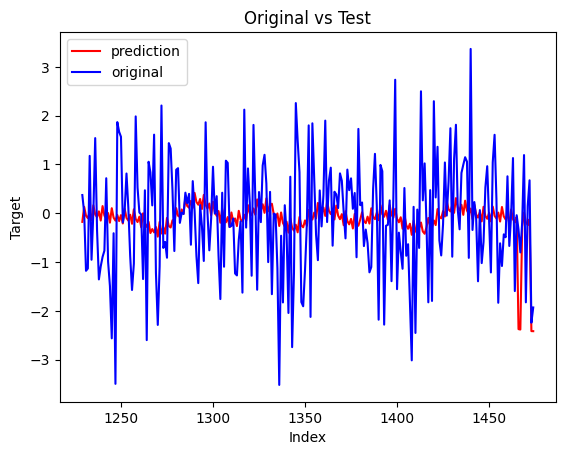

In [18]:
import matplotlib.pyplot as plt
plt.plot(forecast.iloc[-246:,:].yhat,'r', label='prediction')
plt.plot(df.iloc[-246:,:].y,'b', label='original')
plt.xlabel('Index')
plt.ylabel('Target')
plt.legend()
plt.title('Original vs Test')
plt.show()

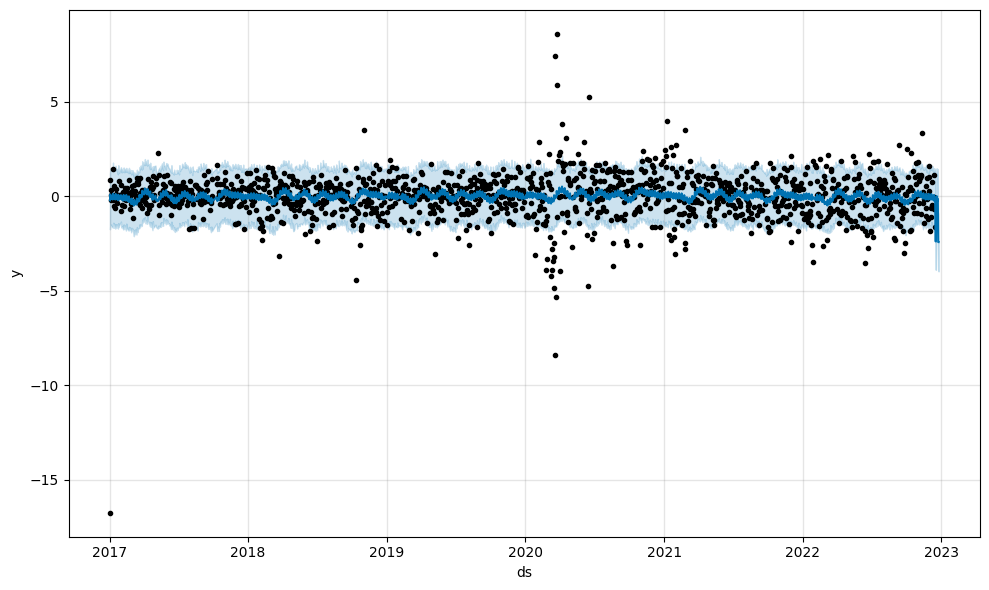

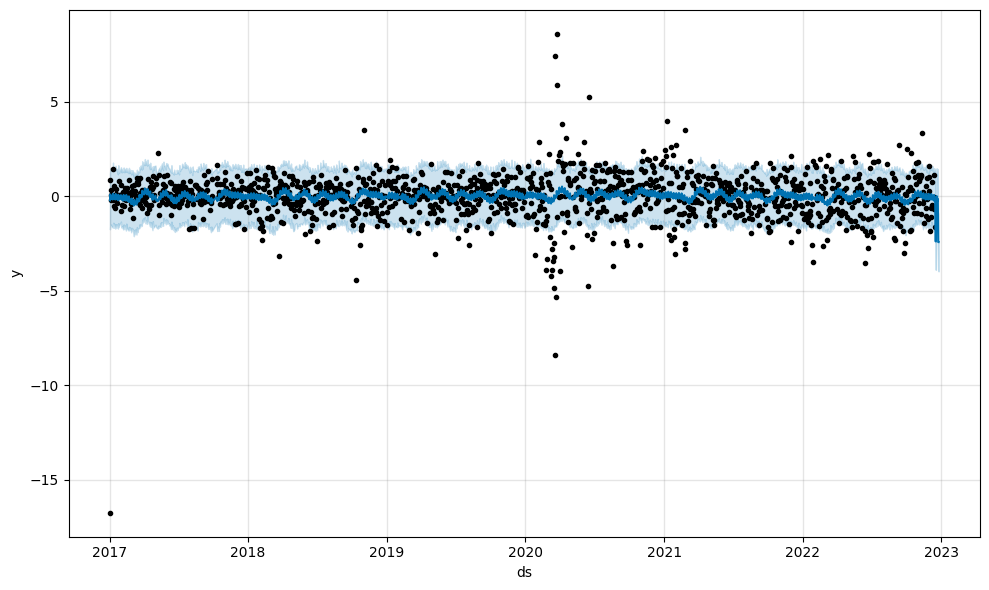

In [13]:
# 모델이 제공하는 시각화
model.plot(forecast)

- prophet 모델 gridsearch